# Why do we not want kids?

Exploring the connection between education and kids: Does the length of a woman's education, affect the amount of kids, that she gets?

To explore the relationship, we use data from Statistikbanken, on fertility and education. The fertility is illustrated using the fertility quotient which is live births per 1,000 women in the fertile age groups (15-49). The education is illustrated as the population with a higher education. 


To conduct the analysis, we have used data from Statistikbanken.dk on the fertility quotient and population with a longer education in different municipalities. Specifically; Thisted, Aalborg and Copenhagen. 

First, we explore the datasets by plotting the total development in education in the three municipalities. Notably, the plot shows a significant increase in all three cities. 

Next, we want to explore, is there could be a link between having a longer education and the number of kids women give birth to. This is done by, plotting the total amount of people with a higher education against the fertility quotient in the three municipalities. The plots indicate, that there is a link between the two.

To find out, if it is the urban or the rural areas that drive the change in recent years. We have calculated the percentage of the population in each municipality with a higher education. From the results we can see, that the fertility quotient in Thhisted has seen the biggest decline in recent years, even though all municipalities have had a rather large increase in the percent of people with a higher education. We can therefore conclude, that as the rural areas start to get longer education, we will see a large effect on the fertility quotient. 


 In the analysis, we compare our findings to other countries, using data from Eurostat. From this we can conclude, that the trend is also happening in other countries. 

To run our code, you have to install the DST API wrapper and Pandas-datareader

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# The DST API wrapper
%pip install git+https://github.com/alemartinello/dstapi

# A wrapper for multiple APIs with a pandas interface
%pip install pandas-datareader

# User written modules
import dataproject

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/g9/q3t9r2bx0bdg9g0lrb95lhzh0000gn/T/pip-req-build-kso76eql
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/g9/q3t9r2bx0bdg9g0lrb95lhzh0000gn/T/pip-req-build-kso76eql
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Reading and cleaning data

We use the API from DST for table HFUD11 that includes data regarding the education in Denmark amongst the population. We initially look at the municipalities of Thisted, Aalborg and Copenhagen.

Cleaning the data

In [39]:
# Import Table of HFUD11 cleaned 
from dataproject import HFUD11_data
dataind = HFUD11_data()
#define municipalities to filter
municipalities = ["Aalborg", "Thisted", "Copenhagen"]
#filter the data
ind_api = dataind.loc[dataind["municipality"].isin(municipalities)]
ind_api.head(10)

Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,municipality,year,highereducation
577,Aalborg,2008,9481
1277,Aalborg,2009,9953
505,Aalborg,2010,10469
1064,Aalborg,2011,10993
1674,Aalborg,2012,11719
385,Aalborg,2013,12276
390,Aalborg,2014,12806
1499,Aalborg,2015,13724
835,Aalborg,2016,14781
1419,Aalborg,2017,15501


The table above shows, how many people of all ages and ethnicities in Denmark, have a higher education in Aalborg, Thisted, and Copenhagen and years. We have chosen the three municipalities to get a differentiated perspective on the numbers. Thisted represents rural municipalities, where people do not have much education. Copenhagen is the capital of Denmark, where the highly educated and ambitious often prefer to live. Aalborg is a mix between Thisted and Copenhagen since it is the third biggest city in Denmark but located in the Nothern Jutland.

We use the API from DST for table FOD407 that includes data regarding fertility (births per 1000 women)  in Denmark.

In [40]:
#Import Table of FOD407 cleaned
from dataproject import FOD407_data
fertdata = FOD407_data()
#filter municipalities
fert_api = fertdata.loc[fertdata["municipality"].isin(municipalities)]
fert_api.head(10)

Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00


,municipality,year,fertilityquotient
1622,Aalborg,2006,1681.4
1738,Aalborg,2007,1686.6
1854,Aalborg,2008,1765.2
1970,Aalborg,2009,1724.8
1390,Aalborg,2010,1743.1
2086,Aalborg,2011,1610.9
1506,Aalborg,2012,1624.0
630,Aalborg,2013,1546.2
514,Aalborg,2014,1542.4
230,Aalborg,2015,1639.5


The tables shows the fertility i Aalborg, Copenhagen and Thisted across years in Denmark for women in all ages from 2006 to 2023.

## Exploring each data set

To explore our data sets, we make an interactive figure. The figure shows how many people have a higher education in the three regions, that we have chosen. 

In [41]:
#First we define the function, that we are plotting
def plot_e(df, municipality): 
    #The boolean series returns true for rows, where the value in the municipality coloumn matches the municipality parameter.
    I = df['municipality'] == municipality
    #df.loc[I:] filters the dataframe using the boolean series to include only those rowsa where the municipality matches.
    #Set "year" on the x-axis and "highereducation" on the y-axis
    ax=df.loc[I,:].plot(x='year', y='highereducation', style='-o', legend=False)

    # Set the x-axis label
    years = df.loc[I, 'year'].unique()  # Get unique years
    ax.set_xticks(years)  # Set x-ticks to the unique years
    ax.set_xticklabels(years, rotation=45)  # Rotate labels for better visibility

    # Set the y-axis label
    ax.set_ylabel("Population with a highereducation")
    
    plt.show()


#Create the widget interaction.
widgets.interact(plot_e, 
    #ind_api is fixed
    df = widgets.fixed(ind_api),
    #creates a dropdoen widget for selecting municipality. The default value is selected as Copenhagen. 
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=ind_api.municipality.unique(), 
                                    value='Copenhagen')
); 


interactive(children=(Dropdown(description='Municipality', index=1, options=('Aalborg', 'Copenhagen', 'Thisted…

When changing the municipality we can see, that the amount of people with a higher education, has been increasing for all 3 cities since 2008. Copenhagen has the highest total amont of people with a higher education.

# Merge data sets

Before we merge the data sets, we check to see that the years are the same in the datasets, and the dataset has information about the same municipalities.

In [42]:
#Check for difference in years
diff_y = [y for y in fert_api.year.unique() if y not in ind_api.year.unique()] 
print(f'years in fertility data, but not in education data: {diff_y}')

#Check for difference in municipalities
diff_m = [m for m in fert_api.municipality.unique() if m not in ind_api.municipality.unique()] 
print(f'muncipalities in fertility data, but not in education data: {diff_m}')

years in fertility data, but not in education data: [2006, 2007]
muncipalities in fertility data, but not in education data: []


From the above we can see, that the dataset regarding fertility contains data from the years 2006 and 2007, that is not contained in the dataset about education. 

Otherwise, the two datasets contains information about fertility and municiaplities in the same years. 

We are now going to merge the two datasets using the left merge method, so we don't get the years 2006 and 2007.

In [43]:
# Merge the two datasets on both 'municipality' and 'year' using a left merge.
inner_with_area = pd.merge(ind_api, fert_api, on=['municipality', 'year'], how='left')

#Converting values to numeric types
inner_with_area['fertilityquotient'] = pd.to_numeric(inner_with_area['fertilityquotient'], errors='coerce')

# Display the dataframe
print(inner_with_area.head(10))

  municipality  year  highereducation  fertilityquotient
0      Aalborg  2008             9481             1765.2
1      Aalborg  2009             9953             1724.8
2      Aalborg  2010            10469             1743.1
3      Aalborg  2011            10993             1610.9
4      Aalborg  2012            11719             1624.0
5      Aalborg  2013            12276             1546.2
6      Aalborg  2014            12806             1542.4
7      Aalborg  2015            13724             1639.5
8      Aalborg  2016            14781             1727.2
9      Aalborg  2017            15501             1627.8


The table above shows, how many people have a BA degree and the fertility kvotient in Aalborg, Thisted and Copenhagen.

# Analysis

To find a relationship between the fertility and amount of people with a higher education, we plot the development in fertility and education in the same graph. 

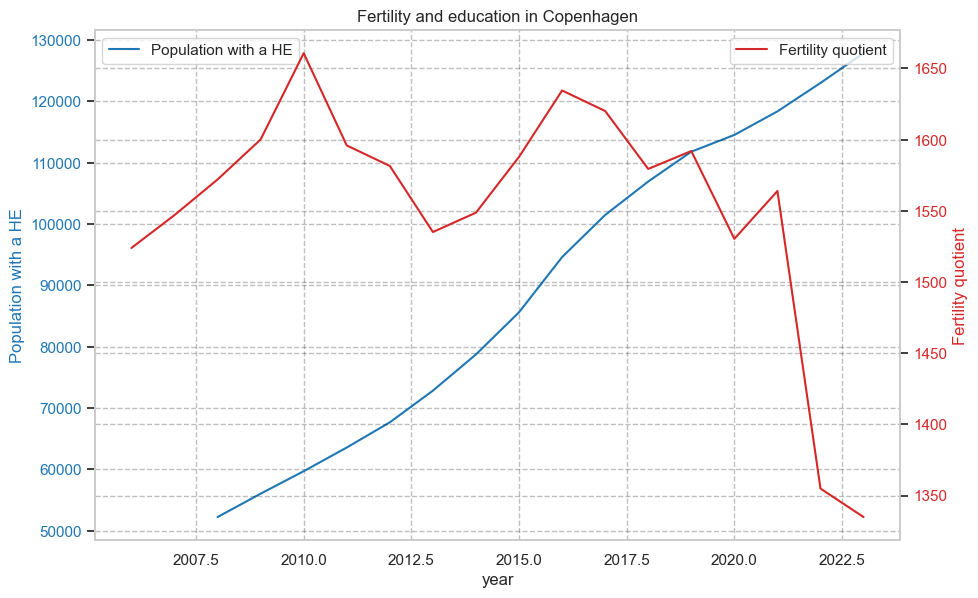

In [44]:
from dataproject import plot_fer_HE_copenhagen

# Call the function to plot
plot_fer_HE_copenhagen(ind_api, fert_api)

From the table above, we can see, that the number of people with a higher education has increased. Opposite the fertilityquotient has decreased. 

From 2006-2020 the fertility seemed rather constant. However, it fell drastically in 2020. In the same period, the amount of people with a higher education increased significantly compared to prior years. 

This could indicate, that when people take a longer education, they get fewer kids. 

We want to determine, if the same relationsship is evident in Thisted and Aalborg. 

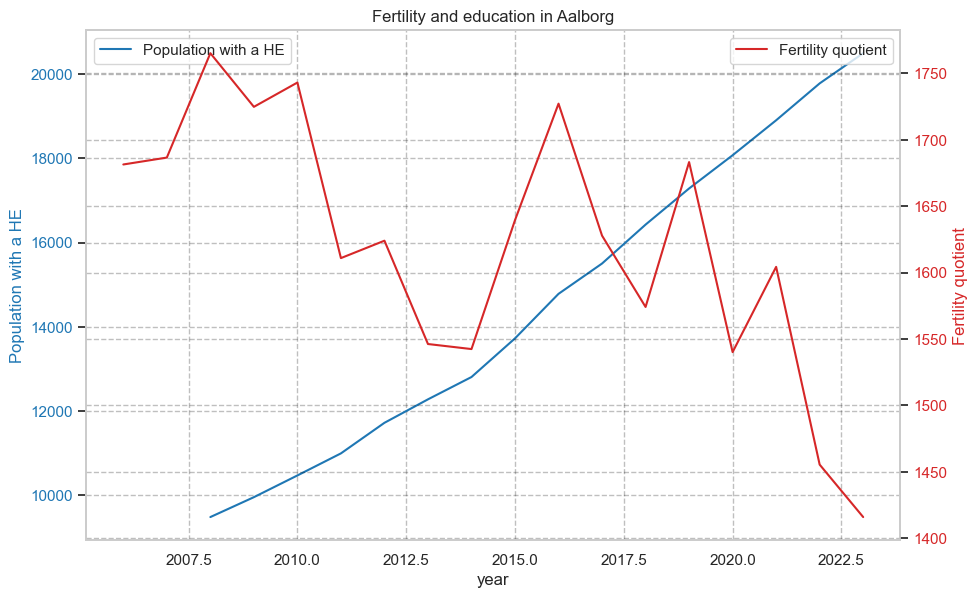

In [45]:
#Plot for Aalborg
from dataproject import plot_fer_HE_aalborg

# Call the function to plot
plot_fer_HE_aalborg(ind_api, fert_api)

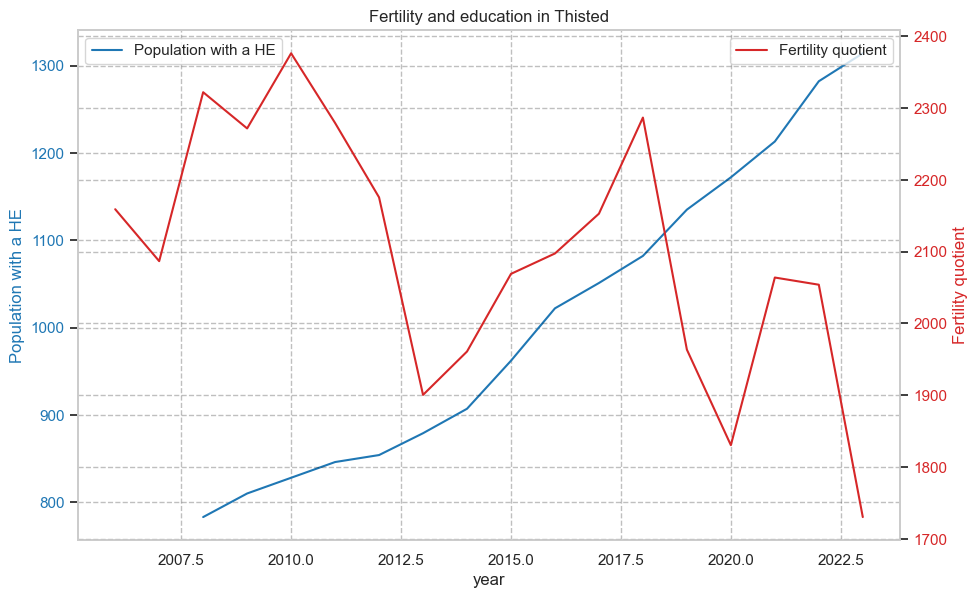

In [46]:
#Plot for Thisted
from dataproject import plot_fer_HE_thisted

# Call the function to plot
plot_fer_HE_thisted(ind_api, fert_api)

The data from Thisted and Aalborg shows the same as Copenhagen. For the last years, people have been taking longer education, which might have led to a decrease in the fertilityquotient. Especially in the last few years, the amount of people with a bachelor education has increased significantly and the fertilityquotient has decreased a lot. 

# Education and fertility as a percent of the population in the areas

To get a proxy of how many people live in Thisted, Aalborg and Copenhagen, we have made a new data import of HFUDD11. In the import, we have not filtered for education, and can therefore use it as a proxy for the total population.

In [47]:
# Import data on total population for each municipality
from dataproject import population_data

pop_data = population_data()
pop_data.head(10)

Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,municipality,year,totalpop
2,Aalborg,2008,142461
5,Aalborg,2009,143297
8,Aalborg,2010,144662
11,Aalborg,2011,146765
14,Aalborg,2012,148482
17,Aalborg,2013,150456
20,Aalborg,2014,151679
23,Aalborg,2015,152973
26,Aalborg,2016,153843
29,Aalborg,2017,154137


In [48]:
# Ensure 'year' and 'municipality' are strings in pop_data
pop_data['year'] = pop_data['year'].astype(str)
pop_data['municipality'] = pop_data['municipality'].astype(str)

# Ensure 'year' and 'municipality' are strings in inner_with_area
inner_with_area['year'] = inner_with_area['year'].astype(str)
inner_with_area['municipality'] = inner_with_area['municipality'].astype(str)

In [49]:
# Merge on 'municipality' and 'year' using the left-method
merged_data = pd.merge(inner_with_area, pop_data, on=['municipality', 'year'], how='left')

# Display
print(merged_data.head(10))

  municipality  year  highereducation  fertilityquotient  totalpop
0      Aalborg  2008             9481             1765.2    142461
1      Aalborg  2009             9953             1724.8    143297
2      Aalborg  2010            10469             1743.1    144662
3      Aalborg  2011            10993             1610.9    146765
4      Aalborg  2012            11719             1624.0    148482
5      Aalborg  2013            12276             1546.2    150456
6      Aalborg  2014            12806             1542.4    151679
7      Aalborg  2015            13724             1639.5    152973
8      Aalborg  2016            14781             1727.2    153843
9      Aalborg  2017            15501             1627.8    154137


In [50]:
# Calculate BA/totalpop 
merged_data['HE_percentage'] = (merged_data['highereducation'] / merged_data['totalpop']) * 100

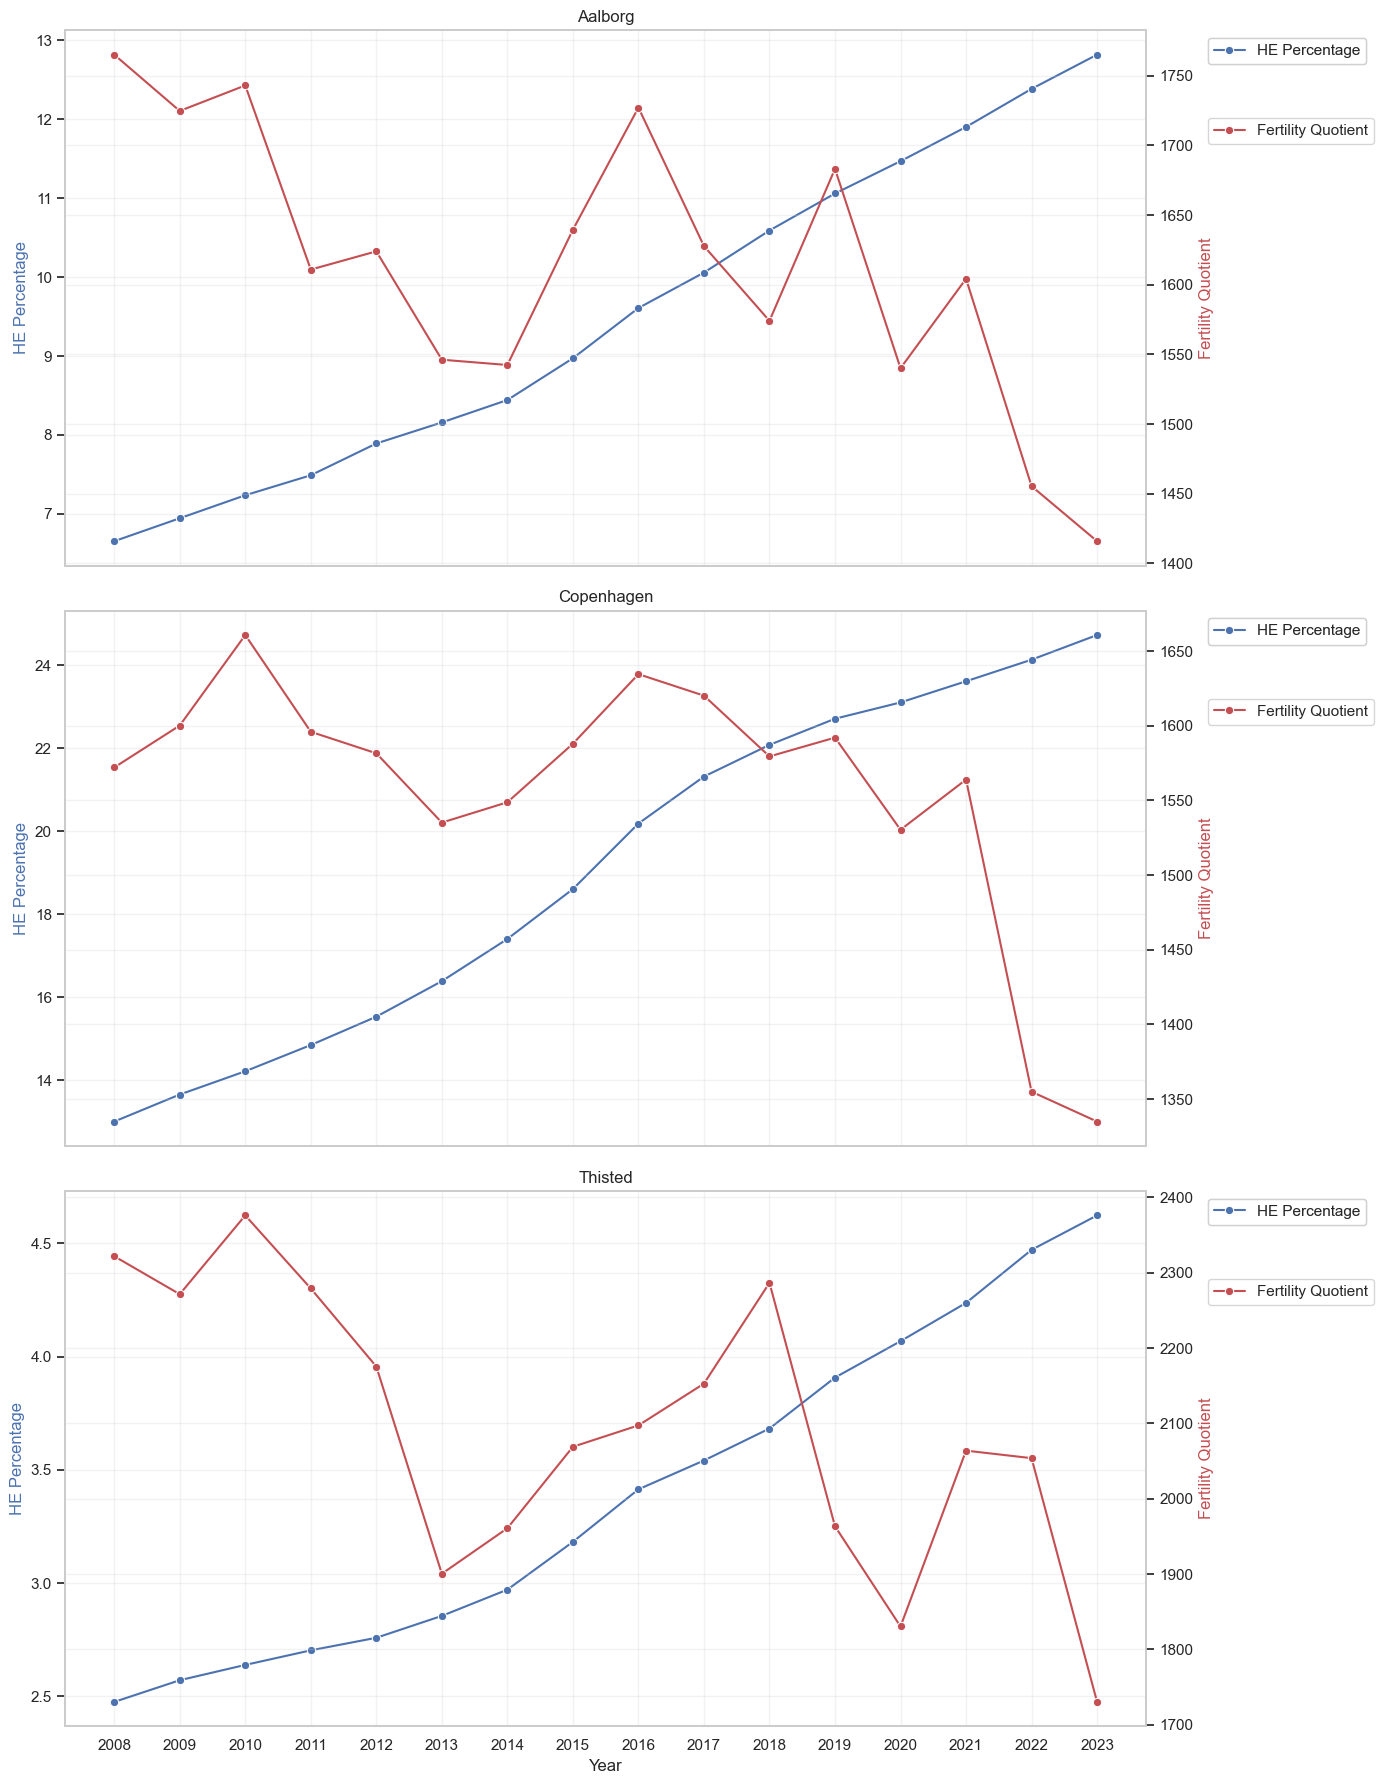

In [51]:
# Filter data for each municipality
aalborg_data = merged_data[merged_data['municipality'] == 'Aalborg']
copenhagen_data = merged_data[merged_data['municipality'] == 'Copenhagen']
thisted_data = merged_data[merged_data['municipality'] == 'Thisted']

# Style of the plot
sns.set(style="whitegrid")

# Create figure and axis objects for the plots
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Plot data for a given municipality
def plot_municipality(data, ax, title):
    ax1 = ax
    ax2 = ax1.twinx()
    sns.lineplot(data=data, x='year', y='HE_percentage', marker='o', ax=ax1, label='HE Percentage', color='b')
    sns.lineplot(data=data, x='year', y='fertilityquotient', marker='o', ax=ax2, label='Fertility Quotient', color='r')
    ax1.set_title(title)
    ax1.set_ylabel('HE Percentage', color='b')
    ax2.set_ylabel('Fertility Quotient', color='r')
    he_legend = ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fertility_legend = ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85))
    ax1.add_artist(he_legend)  # Ensure the HE legend is on top

# Plot for Aalborg
plot_municipality(aalborg_data, axes[0], 'Aalborg')

# Plot for Copenhagen
plot_municipality(copenhagen_data, axes[1], 'Copenhagen')

# Plot for Thisted
plot_municipality(thisted_data, axes[2], 'Thisted')

# Set xlabel for the last subplot
axes[2].set_xlabel('Year')

# Layout
plt.tight_layout()

# Display the pl

From the above we can see, that the fertilityquotient has seen the biggest decline in Thisted. Thisted also saw the biggest increase in the percent of people with a higher education, increasing from 2.5% to almost 5%. It is therefore indicated, that higher education in the rural areas, drives the big decline in the fertility quotient. We further expand on this by defining urban areas in Denmark and comparing them to rural areas.

# Rural vs Urban municipalities

 Firstly, we will define urban areas as municipalities with populations that exceed 50,000 on average for our time period. This requires an additional API (FOLK1A) from DST in order to obtain the entire population of each municipality at the fourth quarter of each year. Thus, we will not be basing our populations by proxy as before, but rather look at the true values of each municipality for their entire population. We note that fertility quotients for Læsø, Ærø, Samsø, Fanø and Christiansø do not exist. Therefore, we have dropped these municipalities.

In [52]:
#Import table from FOLK1A
from dataproject import FOLK1A_data

#Assign the data to the variable
totpop_api = FOLK1A_data()
#Show the table
totpop_api.head(5)

Table FOLK1A: Population at the first day of the quarter by region, sex, age, marital status and time
Last update: 2024-05-10T08:00:00


,municipality,year,totalpop
71,Aabenraa,2008,60368
176,Aabenraa,2009,60037
281,Aabenraa,2010,59811
386,Aabenraa,2011,59645
491,Aabenraa,2012,59328


Now we will find the average population for each municipality in the period 2008-2023. By doing so, we can filter the urban areas from the rural. The average population of a municipality for the given time period can be defined as:

$ Average = \frac{\sum^n_{i=1} totalpop_i}{n} $

Where "n" is the number of years, and totalpop is the population for each period for municipality "i".

In [53]:
#Groups the data in municipalities and calculate mean
average_totalpop = totpop_api.groupby('municipality')['totalpop'].mean()
#Create a series that only includes municipalities with an average total population greater than 50,000
urban_area = average_totalpop[average_totalpop > 50000]
#Create a series that only include municipalities with an average total population less than or equal to 50,000
rural_area = average_totalpop[average_totalpop <= 50000]

 We now aim to take an average of the urban areas and compare their higher education levels and fertility with rural areas. We make use of the same datasets as before, merely unfiltered for municipalities. Merging them yields:

In [54]:
# We use the left merge method
# First, we merge the two datasets on both 'municipality' and 'year' using a left merge.
mergindata = pd.merge(dataind, fertdata, on=['municipality', 'year'], how='left')

Now we wish to merge with the total population as well. We need to ensure that year and municipality are defined as strings in both totpop_api and mergindata:

In [55]:
# Ensure 'year' and 'municipality' are strings in totpop_api
totpop_api['year'] = totpop_api['year'].astype(str)
totpop_api['municipality'] = totpop_api['municipality'].astype(str)

# Ensure 'year' and 'municipality' are strings in mergindata
mergindata['year'] = mergindata['year'].astype(str)
mergindata['municipality'] = mergindata['municipality'].astype(str)

# Merge on 'municipality' and 'year' using the left-method
mergewithpop = pd.merge(mergindata, totpop_api, on=['municipality', 'year'], how='left')

Now grouping the merged data into urban and rural municipalities. This is done in order to calculate the percentage of people with a higher education for the areas, followed by grouping the areas to find an average for fertility and education levels.

In [56]:
# Filter the DataFrame based on the index of urban and rural municipalities. 
urban_df = mergewithpop[mergewithpop['municipality'].isin(urban_area.index)]
rural_df = mergewithpop[mergewithpop['municipality'].isin(rural_area.index)]

We now calculate the percentage of rural and urban populations with a higher education level, respectively. 

In [57]:
# Calculate education/pop percentage of urban and rural areas
rural_df['HE_percentage'] = (rural_df['highereducation'] / rural_df['totalpop']) * 100
urban_df['HE_percentage'] = (urban_df['highereducation'] / urban_df['totalpop']) * 100

By calculating the average of people with higher education and the average fertility for rural and urban areas combined we can compare the two for our given time period. This is done by grouping all the municipalities in rural/urban areas, and finding their average level for each year. Thus we can get the average education level and fertility in rural and urban areas for each year and compare these.

In [58]:
#Average fertility and education for rural areas
rural_fert_avg = rural_df.groupby('year')['fertilityquotient'].mean()
rural_high_avg= rural_df.groupby('year')['HE_percentage'].mean()
#Average fertility and education for urban areas
urban_fert_avg = urban_df.groupby('year')['fertilityquotient'].mean()
urban_high_avg = urban_df.groupby('year')['HE_percentage'].mean()

Plotting the results in a graph yields:

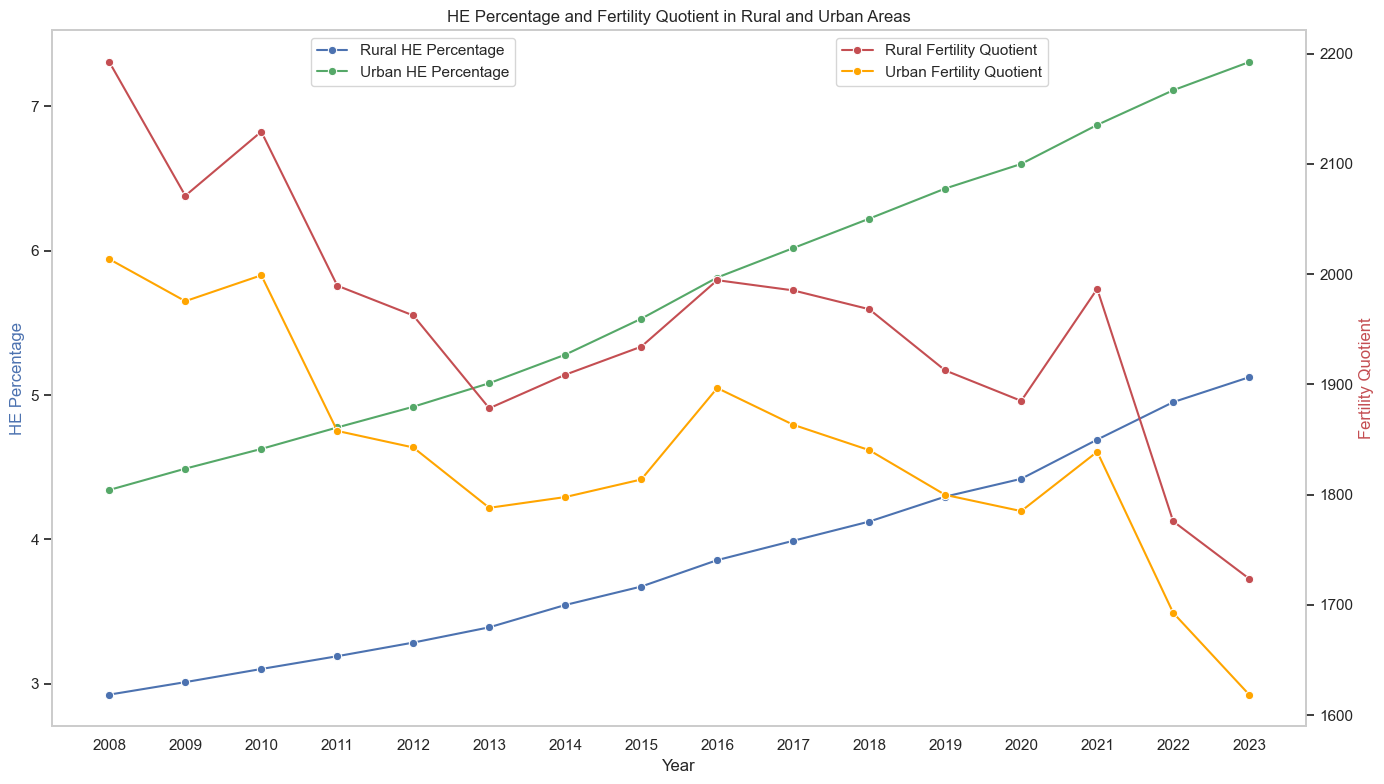

In [59]:
# Filter data for rural and urban areas
rural_data = rural_df
urban_data = urban_df

# Style of the plot
sns.set(style="whitegrid")

# Figure and axis for plot
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Plot rural areas education and fertility levels
sns.lineplot(data=rural_data, x='year', y='HE_percentage', marker='o', ax=ax1, label='Rural HE Percentage', color='b', ci=None) # ci=None removes confidence interval
sns.lineplot(data=rural_data, x='year', y='fertilityquotient', marker='o', ax=ax2, label='Rural Fertility Quotient', color='r', ci=None) 

# Plot urban areas education and fertility levels
sns.lineplot(data=urban_data, x='year', y='HE_percentage', marker='o', ax=ax1, label='Urban HE Percentage', color='g', ci=None) # ci=None removes confidence interval
sns.lineplot(data=urban_data, x='year', y='fertilityquotient', marker='o', ax=ax2, label='Urban Fertility Quotient', color='orange', ci=None)

# labels and title for the plot
ax1.set_ylabel('HE Percentage', color='b')
ax2.set_ylabel('Fertility Quotient', color='r')
ax1.set_xlabel('Year')
ax1.set_title('HE Percentage and Fertility Quotient in Rural and Urban Areas')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(0.2, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.8, 1))

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

# Layout
plt.tight_layout()

# Display plot
plt.show()


The graph above shows education levels and fertility quotients of rural and urban areas. Urban areas initially have a higher proportion of higher educated people than rural areas. On the other hand, fertility is lower initially. Overall the same pattern emerges for rural and urban areas: Higher level of education seems to inversely correlate with fertility quotients. The general trend seems to be the same for rural and urban areas, indicating no major differences between the two. Furthermore, a noticeable drop occurs in fertility in 2021, and at the begining of the time frame fertility is in a downward trend. One could assume that economic consequences of the financial crisis in 2007-2008, along with COVID-19, heavily impacted fertility quotients.

# Other Countries

We now want to analyze, if the observations above, are also evident in other countries:

First, we clean the data for education across countries. This requires country mapping such that Geo Codes are the same for data from EuroStat and The World Bank. Since we are only interested in tertiary education, we get the following:

In [60]:
from dataproject import educ_c
# Display the cleaned DataFrame after removing columns
print("\nEducation DataFrame after removing columns 1-7 and column 11:")
educ_c = educ_c()
educ_c.head(5)


Education DataFrame after removing columns 1-7 and column 11:


,Country,Years,% tertiary educ.
0,AUT,2011,20.9
1,AUT,2012,22.8
2,AUT,2013,24.9
3,AUT,2014,38.4
4,AUT,2015,38.6


Now we pivot the dataset to show education levels grouped by country codes.

In [61]:
#Sorting Education data
# Check for duplicates in the 'geo' column
duplicates = educ_c['Country'].duplicated()


# Sort and index the dataframe by the years (2011-2021) for each country
educ_sorted = educ_c.set_index('Country').sort_index(axis=1).reset_index()


# Pivot the sorted DataFrame to show indicator values for each country
educ_pivoted = educ_sorted.pivot_table(index='Years', columns='Country', values='% tertiary educ.', aggfunc='first')

# Display the pivoted table showing the percentage of the total population for ages 25-34 with a tertiary education level
print("\nPivoted table showing indicator values of education for each country:")
educ_pivoted.head(5)


Pivoted table showing indicator values of education for each country:


Country,AUT,BEL,BGR,CHE,CYP,CZE,DEU,DNK,ESP,EST,...,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE,UK
Years,,,,,,,,,,,,,,,,,,,,,
2011,20.9,42.5,27.2,38.0,50.5,25.1,27.6,38.6,40.3,39.0,...,40.0,46.1,39.0,27.5,22.5,22.0,25.5,33.8,42.8,43.8
2012,22.8,43.0,27.2,39.3,53.6,27.8,28.9,40.2,40.4,40.1,...,41.4,45.0,40.8,29.0,23.6,24.9,27.0,35.3,43.5,45.1
2013,24.9,42.7,29.6,41.9,51.4,29.2,29.9,40.9,41.1,40.6,...,43.0,46.7,41.8,30.0,24.4,25.1,29.7,37.4,44.9,45.2
2014,38.4,44.2,31.3,44.2,54.0,29.9,28.4,41.6,41.5,40.6,...,44.3,50.2,42.6,31.4,25.4,27.1,29.8,38.0,46.0,45.8
2015,38.6,43.1,31.8,46.5,54.7,31.0,29.6,43.0,41.0,38.5,...,45.1,49.0,43.2,33.1,25.5,29.8,31.3,40.8,46.5,46.9


We do the same for fertility across countries based on data from The World Bank. Note that fertility is per person, why we have to alter this so it matches our data from DST which shows births per 1000 people.

In [62]:
from dataproject import fert
fert = fert()
fert.head(5)

,Country,Years,Fertility
0,AUT,2011,1430.0
1,AUT,2012,1440.0
2,AUT,2013,1440.0
3,AUT,2014,1460.0
4,AUT,2015,1490.0


In [63]:
# Check for duplicates in the 'Country' column
duplicates = fert['Country'].duplicated()


# Sort and index the dataframe by the years (2011-2021) for each country
fert_sorted = fert.set_index('Country').sort_index(axis=1).reset_index()

# Pivot the sorted DataFrame to show indicator values for each country
fert_pivoted = fert_sorted.pivot_table(index='Years', columns='Country', values='Fertility', aggfunc='first')

# Display the pivoted table showing Fertility rates
print("\nPivoted table showing fertility values for each country:")
fert_pivoted.head(5)


Pivoted table showing fertility values for each country:


Country,AUT,BEL,BGR,CHE,CYP,CZE,DEU,DNK,ESP,EST,...,MNE,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
Years,,,,,,,,,,,,,,,,,,,,,
2011,1430.0,1810.0,1510.0,1520.0,1360.0,1430.0,1390.0,1750.0,1340.0,1610.0,...,1650.0,1760.0,1880.0,1330.0,1350.0,1470.0,1400.0,1450.0,1560.0,1900.0
2012,1440.0,1800.0,1500.0,1520.0,1386.0,1450.0,1410.0,1730.0,1320.0,1560.0,...,1720.0,1720.0,1850.0,1330.0,1280.0,1520.0,1450.0,1340.0,1580.0,1910.0
2013,1440.0,1760.0,1480.0,1520.0,1305.0,1460.0,1420.0,1670.0,1270.0,1520.0,...,1730.0,1680.0,1780.0,1290.0,1210.0,1460.0,1430.0,1340.0,1550.0,1890.0
2014,1460.0,1740.0,1530.0,1540.0,1315.0,1530.0,1470.0,1690.0,1320.0,1540.0,...,1750.0,1710.0,1750.0,1320.0,1230.0,1560.0,1460.0,1370.0,1580.0,1880.0
2015,1490.0,1700.0,1530.0,1540.0,1326.0,1570.0,1500.0,1710.0,1330.0,1580.0,...,1740.0,1660.0,1720.0,1320.0,1310.0,1620.0,1460.0,1400.0,1570.0,1850.0


Testing if the dataset contains the same information, or if some data is missing

In [64]:
print(f'Years in education data: {educ_sorted.Years.unique()}')
print(f'country in education data = {len(educ_sorted.Country.unique())}')
print(f'Years in fertility data: {fert_sorted.Years.unique()}')
print(f'country in fertility data = {len(fert_sorted.Country.unique())}')

diff_y = [y for y in fert_sorted.Years.unique() if y not in educ_sorted.Years.unique()] 
print(f'years in fertility data, but not in education data: {diff_y}')

diff_m = [m for m in fert_sorted.Country.unique() if m not in educ_sorted.Country.unique()] 
print(f'countries in fertility data, but missing data points in education data: {diff_m}')

Years in education data: [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
country in education data = 34
Years in fertility data: [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
country in fertility data = 34
years in fertility data, but not in education data: []
countries in fertility data, but missing data points in education data: ['GBR']


We note that education data for Great Britain is missing at some points (due to BREXIT). Thus we drop Great Britain:

In [65]:
#Drop observations from GBR
fert_sorted = fert_sorted[fert_sorted['Country'] != 'GBR']
educ_sorted = educ_sorted[educ_sorted['Country'] != 'GBR']

We merge the two datasets, grouped by country codes and variables:

In [66]:
# Perform the merge on 'Country' and 'Years' columns between educ_sorted and fert_sorted DataFrames
merged = pd.merge(educ_sorted, fert_sorted, on=['Country', 'Years'], how='left')


# Assign the 'Fertility' series from the 'fert_sorted_ to 'merged' DataFrame numeric
merged['Fertility'] = pd.to_numeric(fert_sorted['Fertility'], errors='coerce')

# Rearrange columns in desired order
merged = merged[['Country', 'Years', 'Fertility', '% tertiary educ.']]

# Merge the two pivoted tables on the index
merged_pivoted = pd.merge(fert_pivoted, educ_pivoted, left_index=True, right_index=True, suffixes=('_Fertility', '_% tertiary educ.'))

# Display the merged DataFrame showing both values side by side for each country
merged_pivoted.head(11)

Country,AUT_Fertility,BEL_Fertility,BGR_Fertility,CHE_Fertility,CYP_Fertility,CZE_Fertility,DEU_Fertility,DNK_Fertility,ESP_Fertility,EST_Fertility,...,NLD_% tertiary educ.,NOR_% tertiary educ.,POL_% tertiary educ.,PRT_% tertiary educ.,ROU_% tertiary educ.,SRB_% tertiary educ.,SVK_% tertiary educ.,SVN_% tertiary educ.,SWE_% tertiary educ.,UK
Years,,,,,,,,,,,,,,,,,,,,,
2011,1430.0,1810.0,1510.0,1520.0,1360.0,1430.0,1390.0,1750.0,1340.0,1610.0,...,40.0,46.1,39.0,27.5,22.5,22.0,25.5,33.8,42.8,43.8
2012,1440.0,1800.0,1500.0,1520.0,1386.0,1450.0,1410.0,1730.0,1320.0,1560.0,...,41.4,45.0,40.8,29.0,23.6,24.9,27.0,35.3,43.5,45.1
2013,1440.0,1760.0,1480.0,1520.0,1305.0,1460.0,1420.0,1670.0,1270.0,1520.0,...,43.0,46.7,41.8,30.0,24.4,25.1,29.7,37.4,44.9,45.2
2014,1460.0,1740.0,1530.0,1540.0,1315.0,1530.0,1470.0,1690.0,1320.0,1540.0,...,44.3,50.2,42.6,31.4,25.4,27.1,29.8,38.0,46.0,45.8
2015,1490.0,1700.0,1530.0,1540.0,1326.0,1570.0,1500.0,1710.0,1330.0,1580.0,...,45.1,49.0,43.2,33.1,25.5,29.8,31.3,40.8,46.5,46.9
2016,1530.0,1680.0,1540.0,1540.0,1360.0,1630.0,1600.0,1790.0,1340.0,1600.0,...,45.2,49.2,43.5,35.0,24.8,31.4,33.4,43.0,47.3,47.1
2017,1520.0,1650.0,1560.0,1520.0,1322.0,1690.0,1570.0,1750.0,1310.0,1590.0,...,46.6,48.3,43.6,34.0,25.6,32.2,35.1,44.5,47.4,47.2
2018,1470.0,1620.0,1560.0,1520.0,1320.0,1710.0,1570.0,1730.0,1260.0,1670.0,...,47.6,48.5,43.5,35.1,24.9,32.8,37.2,40.7,47.6,48.1
2019,1460.0,1600.0,1580.0,1480.0,1332.0,1710.0,1540.0,1700.0,1230.0,1660.0,...,49.1,48.4,43.5,37.4,25.5,33.4,39.2,44.1,48.4,49.4


We now find the average fertility rates and education rates in EU, grouped by years:

In [67]:
avgfertEU = fert_sorted.groupby('Years')['Fertility'].mean()
avgeducEU = educ_sorted.groupby('Years')['% tertiary educ.'].mean()

We will now look at the year-to-year growth rates of education level and fertility. This is done by simply taking the difference between two years (np.diff), dividing with the previous years value (avgfertEU[:-1]) and times 100 to find the percentage growth. We also convert the rates to a DataFrame so they can be called in a plot and be indexed on years.

In [110]:
# Calculate the year-to-year growth rates for education
avgeducEU1 = np.array(avgeducEU)

# Calculate the year-to-year growth rates
avg_growth_educ = np.diff(avgeducEU1) / avgeducEU1[:-1] * 100

#Calculate the year-to-year growth rates for fertility
avgfertEU1 = np.array(avgfertEU)

# Calculate the year-to-year growth rates
avg_growth_fert = np.diff(avgfertEU1) / avgfertEU1[:-1] * 100
#print the growth rates to see the extreme values
print(avg_growth_educ)
print(avg_growth_fert)

#Converting these growth rates to a DataFrame so they can be called in a plot

avg_growth_educ2 = pd.DataFrame({
    'Years': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
    '% Change in Tertiary Education': [avg_growth_educ[0], avg_growth_educ[1], avg_growth_educ[2], avg_growth_educ[3], avg_growth_educ[4], avg_growth_educ[5], avg_growth_educ[6], avg_growth_educ[7], avg_growth_educ[8], avg_growth_educ[9]],
}).set_index('Years')

avg_growth_fert2 = pd.DataFrame({
    'Years': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
    '% Change in Fertility': [avg_growth_fert[0], avg_growth_fert[1], avg_growth_fert[2], avg_growth_fert[3], avg_growth_fert[4], avg_growth_fert[5], avg_growth_fert[6], avg_growth_fert[7], avg_growth_fert[8], avg_growth_fert[9]],
}).set_index('Years')


[3.70748299 3.5749426  4.28277391 1.40438776 2.65009732 1.8378063
 1.69722143 2.32378002 1.22225628 3.37200264]
[ 0.43815432 -1.91290584  1.35786677 -0.09513639  1.07664801 -1.22668718
 -0.66573231 -0.95630022 -1.45225753  2.39519756]


Year-to-year growth rates will also be found for all countries individually. First for education levels.

In [113]:
# Initialize an empty DataFrame to store the results of year to year changes in education
y2y_educ = pd.DataFrame()

# Loop through each country and calculate the year-to-year changes
for values in educ_pivoted.columns:
    # Calculate the year-to-year percentage change
    changes = educ_pivoted[values].pct_change() * 100
    # Assign the changes to the result DataFrame
    y2y_educ[values] = changes

# Drop the rows with NaN values
y2y_educ = y2y_educ.dropna()


We will now find the extreme values of the dataset in order to set plot limits and see which countries have the values.

In [129]:
# Find the extreme values in the year-to-year changes in education to set plot limits
educ_min = y2y_educ.values.min()
educ_max = y2y_educ.values.max()
 # Find the countries
min_country_educ = educ_c.loc[educ_c['% tertiary educ.'].idxmin()]['Country']
max_country_educ = educ_c.loc[educ_c['% tertiary educ.'].idxmax()]['Country']
#Print the extreme values
print("\nminimum value in education change:")
print(min_country_educ)
print(educ_min)


print("\nmaximum value in education change:")
print(max_country_educ)
print(educ_max)


minimum value in education change:
AUT
-11.652542372881358

maximum value in education change:
LUX
54.216867469879524


Now for growth rates in fertility:

In [108]:
# Initialize an empty DataFrame to store the results of year to year changes in education
y2y_fert = pd.DataFrame()

# Loop through each country and calculate the year-to-year changes
for values in fert_pivoted.columns:
    # Calculate the year-to-year percentage change
    changes = fert_pivoted[values].pct_change() * 100
    # Assign the changes to the result DataFrame
    y2y_fert[values] = changes

# Drop the rows with NaN values
y2y_fert = y2y_fert.dropna()




minimum value in fertility change:
-9.459459459459463

maximum value in fertility change:
22.137404580152676


NOT DONE YET

We now plot a graph of three different countries within the EU, along with the average levels of fertility and education for all european countries. Note that the country codes can be changed to compare other countries. In our example below, we have chosen Denmark (DNK), Romania (ROU) and Italy (ITA).

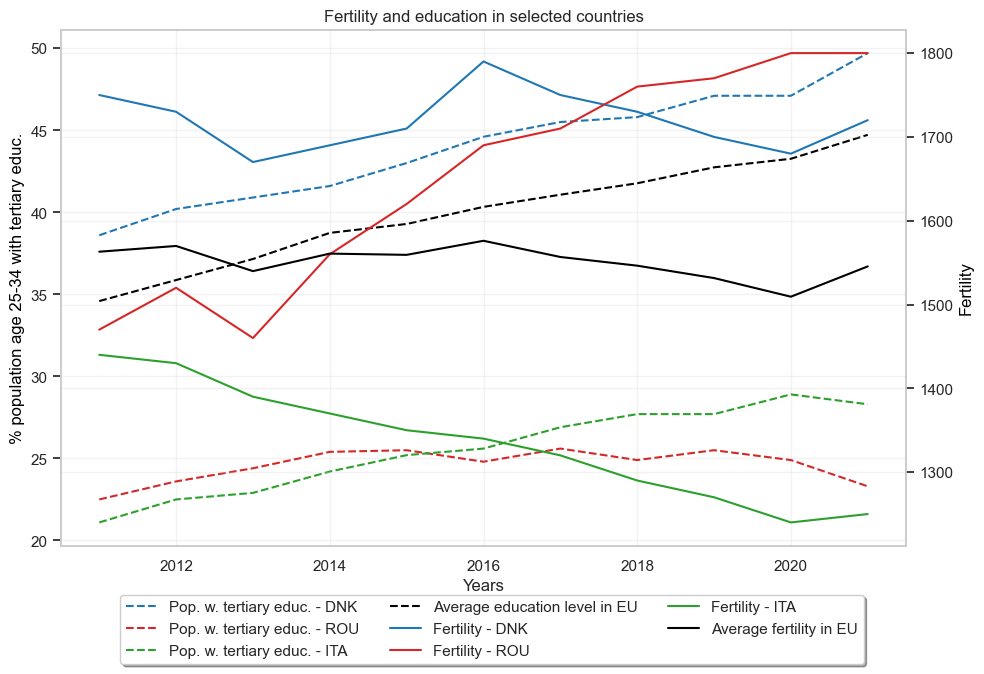

In [71]:
#Plot
from dataproject import plot_fertility_education_country

# List of up to 3 country codes to compare and average values for EU
country_codes = ['DNK', 'ROU', 'ITA']

# Call the function to plot
plot_fertility_education_country(educ_sorted, fert_sorted, country_codes, avgfertEU, avgeducEU)


From the graph above we can conclude that the trend seen in Denmark with longer education and decreasing fertility is the same across other countries in the EU, as well as the average for all countries.

Below is a graph of year to year changes (needs to be cleaner and explanation needed, not done yet)

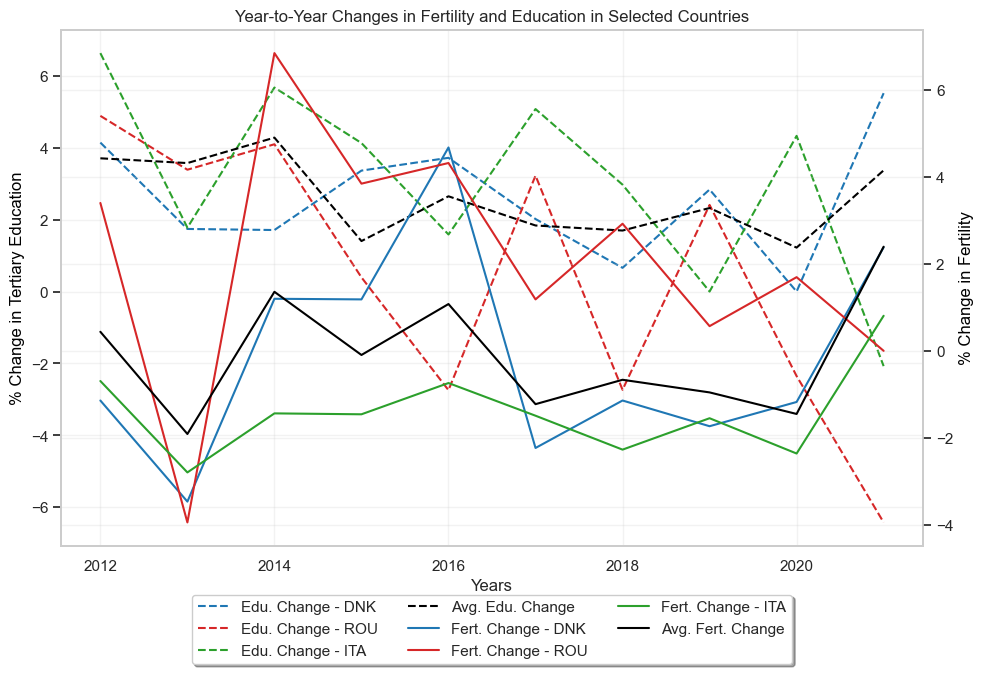

In [90]:
#Plot
from dataproject import plot_growth

# List of up to 3 country codes to compare and average values for EU
country_codes = ['DNK','ROU', 'ITA']

# Call the function to plot
plot_growth(y2y_educ, y2y_fert, country_codes, avg_growth_fert2, avg_growth_educ2)

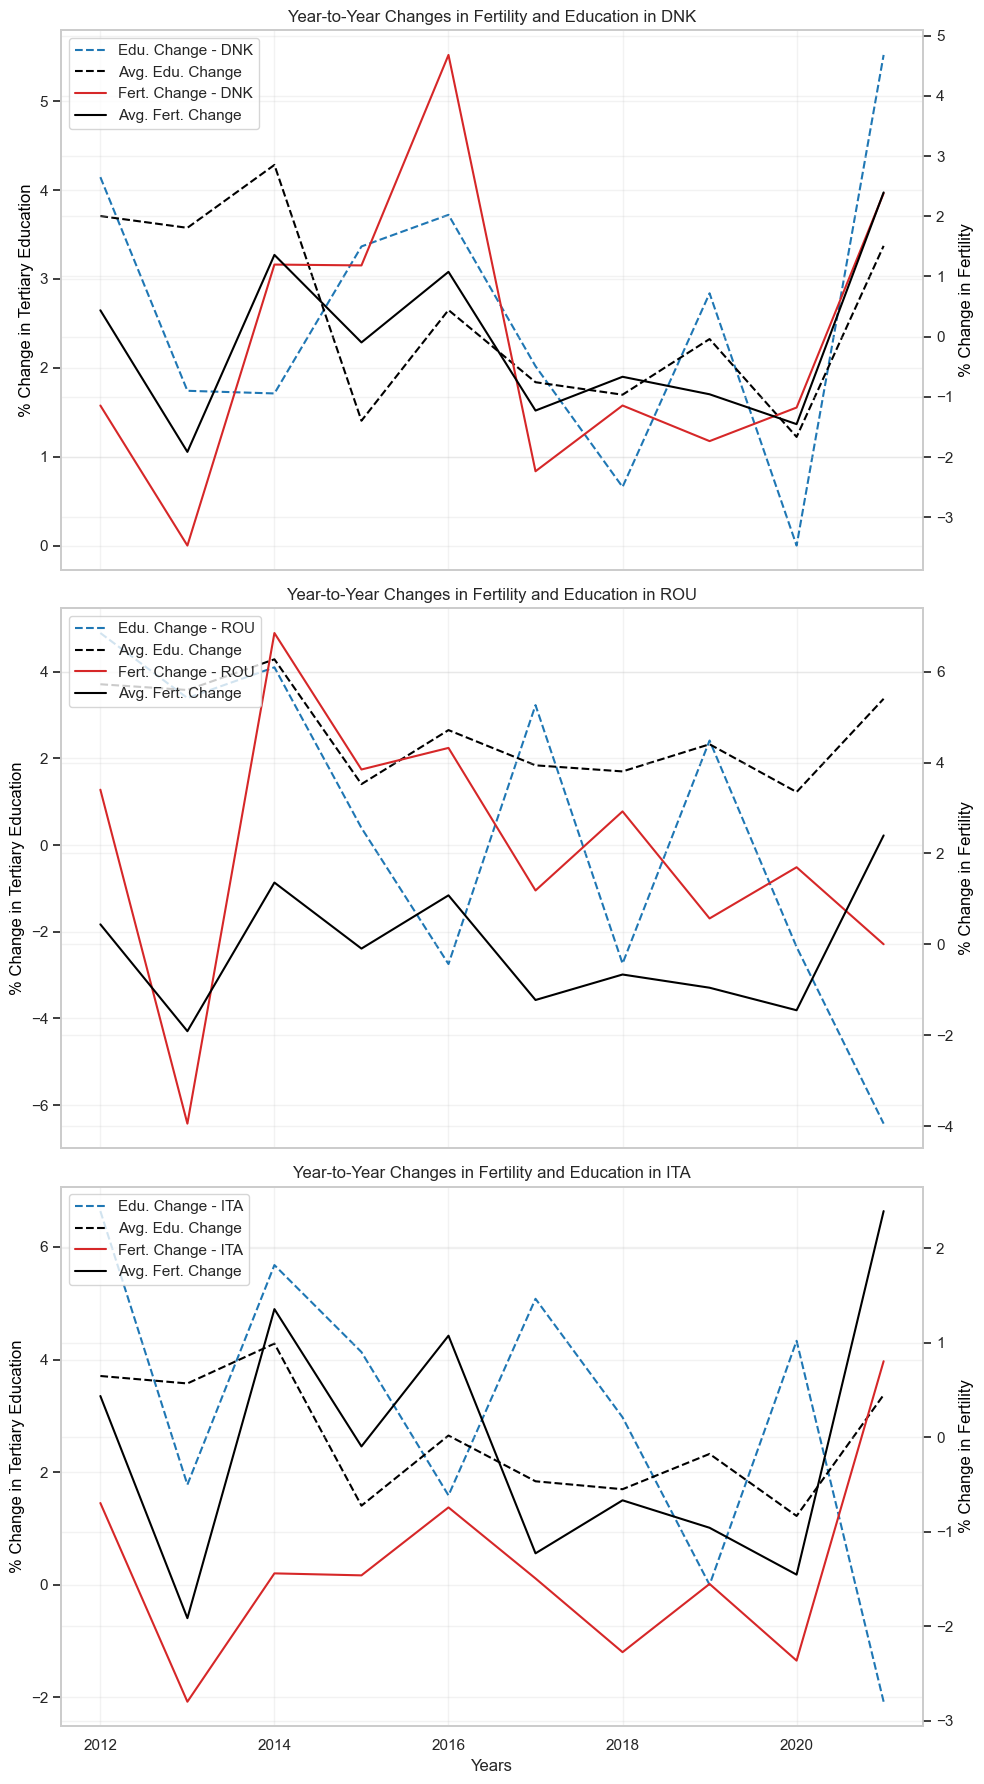

In [98]:
#Plot
from dataproject import plot_growth_subplots


# List of up to 3 country codes to compare and average values for EU
country_codes = ['DNK','ROU','ITA']

# Call the function to plot
plot_growth_subplots(y2y_educ, y2y_fert, country_codes, avg_growth_fert2, avg_growth_educ2)

# Conclusion

From our analysis we can conclude that there might be a negative relationship between longer educations and fertility. However, we can only speak of a correlation, and not so much as to the causation. Other factors such as economic development, social norms and religious impact may have an affect on the fertility, as well as the prevalence of birth control and abortion laws. The project could be expanded to countries that vary from those of the EU, e.g. Sub-Saharan nations or South-East Asian nations to gain insight on the correlation with respect to nations with varying social structures.